In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

#### Loading data

In [44]:
df = pd.read_csv('OnlineNewsPopularityReduced.csv')
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2014/09/28/jobs-tech-workers/,101,12,332,0.528481,1.0,0.645833,6,3,1,...,0.100000,0.7,-0.145833,-0.166667,-0.125000,0.718182,0.137121,0.218182,0.137121,8600
1,http://mashable.com/2014/09/28/obama-says-u-s-...,101,10,393,0.518817,1.0,0.596899,14,1,1,...,0.250000,0.8,-0.312500,-0.500000,-0.250000,0.500000,0.000000,0.000000,0.000000,23700
2,http://mashable.com/2014/09/28/once-upon-a-tim...,101,13,1643,0.388854,1.0,0.546967,29,4,7,...,0.033333,0.8,-0.227778,-0.800000,-0.050000,0.000000,0.000000,0.500000,0.000000,8400
3,http://mashable.com/2014/09/28/the-simpsons-de...,101,9,272,0.488889,1.0,0.512690,2,2,11,...,0.100000,1.0,-0.416667,-1.000000,-0.166667,0.000000,0.000000,0.500000,0.000000,4800
4,http://mashable.com/2014/09/28/viola-davis-les...,101,12,0,0.000000,0.0,0.000000,0,0,0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.541071,0.067560,0.041071,0.067560,3100


#### A bit of preprocessing, this dataset doesn't require a lot.

In [45]:
df = df[df.n_tokens_content != 0]
df.drop(columns=['url', 'kw_min_min'], inplace=True)

In [46]:
df.dtypes

timedelta                          int64
n_tokens_title                     int64
n_tokens_content                   int64
n_unique_tokens                  float64
n_non_stop_words                 float64
n_non_stop_unique_tokens         float64
num_hrefs                          int64
num_self_hrefs                     int64
num_imgs                           int64
num_videos                         int64
average_token_length             float64
num_keywords                       int64
data_channel_is_lifestyle          int64
data_channel_is_entertainment      int64
data_channel_is_bus                int64
data_channel_is_socmed             int64
data_channel_is_tech               int64
data_channel_is_world              int64
kw_max_min                       float64
kw_avg_min                       float64
kw_min_max                         int64
kw_max_max                         int64
kw_avg_max                       float64
kw_min_avg                       float64
kw_max_avg      

#### Splitting data into train/validation sets

In [47]:
X = df.drop(columns='shares')
columns = X.columns
y = df.shares
y_log = np.log(y)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=.25, random_state=4)

### No regularization Linear Regression

#### Default parameters

In [48]:
model = LinearRegression()
scores = cross_validate(model, X, y_log, cv=4, scoring=['neg_mean_squared_error', 'r2'], return_train_score=True)
print('Train MSE:', scores['train_neg_mean_squared_error'].mean())
print('Test MSE:', scores['test_neg_mean_squared_error'].mean())
print('Train R2:', scores['train_r2'].mean())
print('Test R2:', scores['test_r2'].mean())
model.fit(X, y_log)
cfs = pd.DataFrame({'coef':model.coef_, 'feature':columns})
cfs['cfsabs'] = np.abs(cfs.coef)
print((cfs).sort_values('cfsabs', ascending=False).head(10))
print(model.intercept_)

Train MSE: -0.6367392166577105
Test MSE: -5.289610935268622e+18
Train R2: 0.18915291958772698
Test R2: -8.027322478171472e+18
            coef               feature        cfsabs
30  6.526569e+11    weekday_is_tuesday  6.526569e+11
31  6.366774e+11  weekday_is_wednesday  6.366774e+11
29  6.326761e+11     weekday_is_monday  6.326761e+11
32  6.193172e+11   weekday_is_thursday  6.193172e+11
33  5.756386e+11     weekday_is_friday  5.756386e+11
36  3.313041e+11            is_weekend  3.313041e+11
35  1.737836e+11     weekday_is_sunday  1.737836e+11
34  1.690445e+11   weekday_is_saturday  1.690445e+11
39  3.938517e+06                LDA_02  3.938517e+06
40  3.568554e+06                LDA_03  3.568554e+06
7.430045422961407


### Linear Regression + L1 reg

#### Default parameters

In [49]:
model = Lasso()
scores = cross_validate(model, X, y_log, cv=4, scoring=['neg_mean_squared_error', 'r2'], return_train_score=True)
print('Train MSE:', scores['train_neg_mean_squared_error'].mean())
print('Test MSE:', scores['test_neg_mean_squared_error'].mean())
print('Train R2:', scores['train_r2'].mean())
print('Test R2:', scores['test_r2'].mean())
model.fit(X, y_log)
cfs = pd.DataFrame({'coef':model.coef_, 'feature':columns})
cfs['cfsabs'] = np.abs(cfs.coef)
print((cfs).sort_values('cfsabs', ascending=False).head(10))
print(model.intercept_)

Train MSE: -0.7860909903129962
Test MSE: -0.8105010146814803
Train R2: 0.0
Test R2: -0.05546542691498041
    coef                    feature  cfsabs
0    0.0                  timedelta     0.0
43   0.0  global_sentiment_polarity     0.0
31  -0.0       weekday_is_wednesday     0.0
32  -0.0        weekday_is_thursday     0.0
33  -0.0          weekday_is_friday     0.0
34   0.0        weekday_is_saturday     0.0
35   0.0          weekday_is_sunday     0.0
36   0.0                 is_weekend     0.0
37   0.0                     LDA_00     0.0
38   0.0                     LDA_01     0.0
7.430064470357546


#### Optimized parameters

In [50]:
def objective(trial):
    return cross_val_score(Lasso(alpha=10 ** trial.suggest_float('r', -15, -1)), X, y_log, cv=4, scoring='r2').mean()

In [51]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, 100, n_jobs=-1)

In [10]:
study.best_params

{'r': -1.8673269614938799}

<Axes: xlabel='params_r'>

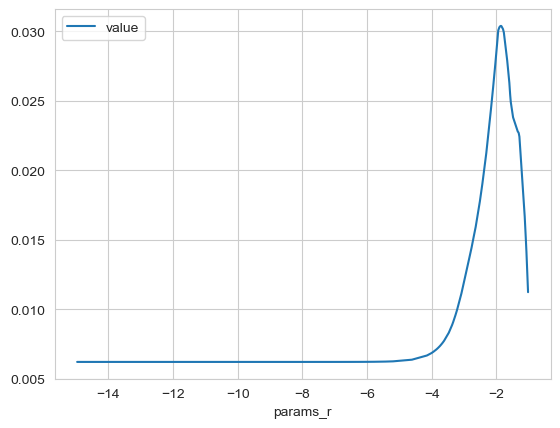

In [23]:
results = study.trials_dataframe()
results = results[['params_r', 'value']]
results.sort_values('params_r').plot('params_r', 'value')

In [12]:
model = Ridge(alpha=10**study.best_params['r'])
scores = cross_validate(model, X, y_log, cv=4, scoring=['neg_mean_squared_error', 'r2'], return_train_score=True)
print('Train MSE:', scores['train_neg_mean_squared_error'].mean())
print('Test MSE:', scores['test_neg_mean_squared_error'].mean())
print('Train R2:', scores['train_r2'].mean())
print('Test R2:', scores['test_r2'].mean())
model.fit(X, y_log)
cfs = pd.DataFrame({'coef':model.coef_, 'feature':columns})
cfs['cfsabs'] = np.abs(cfs.coef)
print((cfs).sort_values('cfsabs', ascending=False).head(10))
print(model.intercept_)

Train MSE: -0.6368055434953066
Test MSE: -0.7629181089745102
Train R2: 0.18906849067039808
Test R2: 0.006181219604454363
        coef                     feature
25  0.348827                  kw_avg_avg
0   0.133198                   timedelta
46  0.117460         rate_positive_words
28  0.116834  self_reference_avg_sharess
19  0.089484                  kw_avg_min
11  0.084967                num_keywords
47  0.076579         rate_negative_words
6   0.067099                   num_hrefs
3   0.059843             n_unique_tokens
35  0.041688           weekday_is_sunday
7.430064471012245


### Linear Regression + L2 reg

#### Default parameters

In [121]:
model = Ridge()
scores = cross_validate(model, X, y_log, cv=4, scoring=['neg_mean_squared_error', 'r2'], return_train_score=True)
print('Train MSE:', scores['train_neg_mean_squared_error'].mean())
print('Test MSE:', scores['test_neg_mean_squared_error'].mean())
print('Train R2:', scores['train_r2'].mean())
print('Test R2:', scores['test_r2'].mean())
model.fit(X, y_log)
cfs = pd.DataFrame({'coef':model.coef_, 'feature':columns})
cfs['cfsabs'] = np.abs(cfs.coef)
print((cfs).sort_values('cfsabs', ascending=False).head(10))
print(model.intercept_)

Train MSE: -0.6368060874084109
Test MSE: -0.7627447315687311
Train R2: 0.1890678102600844
Test R2: 0.006450573806600218
        coef                     feature
25  0.347756                  kw_avg_avg
0   0.133189                   timedelta
28  0.116149  self_reference_avg_sharess
46  0.113402         rate_positive_words
19  0.089150                  kw_avg_min
11  0.085012                num_keywords
47  0.072477         rate_negative_words
6   0.067106                   num_hrefs
3   0.059589             n_unique_tokens
35  0.041678           weekday_is_sunday
7.43006447100969


#### Optimized parameters

In [49]:
def objective(trial):
    return cross_val_score(Ridge(alpha=10 ** trial.suggest_float('r', -15, -1)), X, y_log, cv=4, scoring='r2').mean()

In [50]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, 100, n_jobs=-1)

[I 2023-11-13 19:37:39,387] A new study created in memory with name: no-name-0ccceae7-cab0-4da5-bcd2-af6cd8ef8311
[I 2023-11-13 19:37:39,569] Trial 0 finished with value: 0.00617745709384343 and parameters: {'r': -7.9762568490522}. Best is trial 0 with value: 0.00617745709384343.
[I 2023-11-13 19:37:39,581] Trial 4 finished with value: 0.006178074671597006 and parameters: {'r': -9.044588763365109}. Best is trial 4 with value: 0.006178074671597006.
[I 2023-11-13 19:37:39,594] Trial 2 finished with value: 0.006179298556195978 and parameters: {'r': -8.73011664338554}. Best is trial 2 with value: 0.006179298556195978.
[I 2023-11-13 19:37:39,602] Trial 3 finished with value: 0.006177437689509735 and parameters: {'r': -6.488150286023583}. Best is trial 2 with value: 0.006179298556195978.
[I 2023-11-13 19:37:39,607] Trial 1 finished with value: 0.006178289892661282 and parameters: {'r': -2.5149177066532555}. Best is trial 2 with value: 0.006179298556195978.
[I 2023-11-13 19:37:39,609] Trial 8

In [51]:
study.best_params

{'r': -12.08273191134652}

<Axes: xlabel='params_r'>

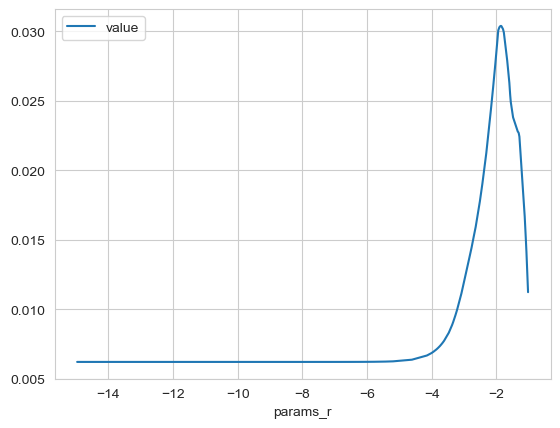

In [23]:
results = study.trials_dataframe()
results = results[['params_r', 'value']]
results.sort_values('params_r').plot('params_r', 'value')

In [24]:
model = Ridge(alpha=10**-study.best_params['r'])
scores = cross_validate(model, X, y_log, cv=4, scoring=['neg_mean_squared_error', 'r2'], return_train_score=True)
print('Train MSE:', scores['train_neg_mean_squared_error'].mean())
print('Test MSE:', scores['test_neg_mean_squared_error'].mean())
print('Train R2:', scores['train_r2'].mean())
print('Test R2:', scores['test_r2'].mean())
model.fit(X, y_log)
cfs = pd.DataFrame({'coef':model.coef_, 'feature':columns})
cfs['cfsabs'] = np.abs(cfs.coef)
print((cfs).sort_values('cfsabs', ascending=False).head(10))
print(model.intercept_)

Train MSE: -0.6377980761210413
Test MSE: -0.7571674400998917
Train R2: 0.18782364604846866
Test R2: 0.014943640061756414
        coef                     feature
25  0.287853                  kw_avg_avg
0   0.132310                   timedelta
11  0.086687                num_keywords
28  0.081560  self_reference_avg_sharess
19  0.069272                  kw_avg_min
6   0.067470                   num_hrefs
3   0.043934             n_unique_tokens
46  0.042937         rate_positive_words
35  0.040971           weekday_is_sunday
50  0.040865       max_positive_polarity
7.430064471052894


### Linear Regression + L1 reg + L2 reg

#### Default parameters

In [42]:
model = ElasticNet()
scores = cross_validate(model, X, y_log, cv=4, scoring=['neg_mean_squared_error', 'r2'], return_train_score=True)
print('Train MSE:', scores['train_neg_mean_squared_error'].mean())
print('Test MSE:', scores['test_neg_mean_squared_error'].mean())
print('Train R2:', scores['train_r2'].mean())
print('Test R2:', scores['test_r2'].mean())
model.fit(X, y_log)
cfs = pd.DataFrame({'coef':model.coef_, 'feature':columns})
cfs['cfsabs'] = np.abs(cfs.coef)
print((cfs).sort_values('cfsabs', ascending=False).head(10))
print(model.intercept_)

Train MSE: -0.7860909903129962
Test MSE: -0.8105010146814803
Train R2: 0.0
Test R2: -0.05546542691498041
    coef                    feature  cfsabs
0    0.0                  timedelta     0.0
43   0.0  global_sentiment_polarity     0.0
31  -0.0       weekday_is_wednesday     0.0
32  -0.0        weekday_is_thursday     0.0
33  -0.0          weekday_is_friday     0.0
34   0.0        weekday_is_saturday     0.0
35   0.0          weekday_is_sunday     0.0
36   0.0                 is_weekend     0.0
37   0.0                     LDA_00     0.0
38   0.0                     LDA_01     0.0
7.430064470357546


#### Optimized parameters

In [26]:
def objective(trial):
    return cross_val_score(ElasticNet(alpha=10 ** trial.suggest_float('r', -15, -1), l1_ratio=trial.suggest_float('l1_ratio', 0, 1)), X, y_log, cv=4, scoring='r2').mean()

In [39]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, 100, n_jobs=-1)

In [28]:
study.best_params

{'r': -1.0004079687946263, 'l1_ratio': 0.053928037568773436}

<Axes: xlabel='params_l1_ratio'>

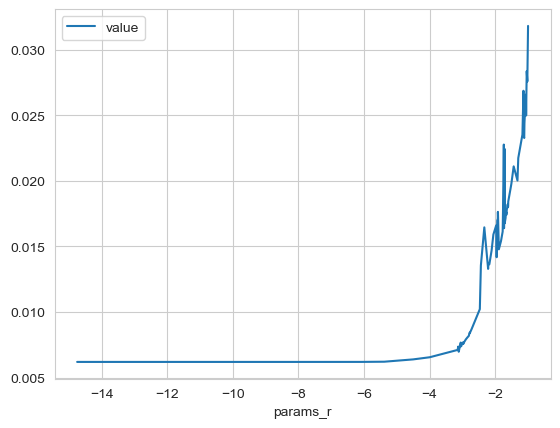

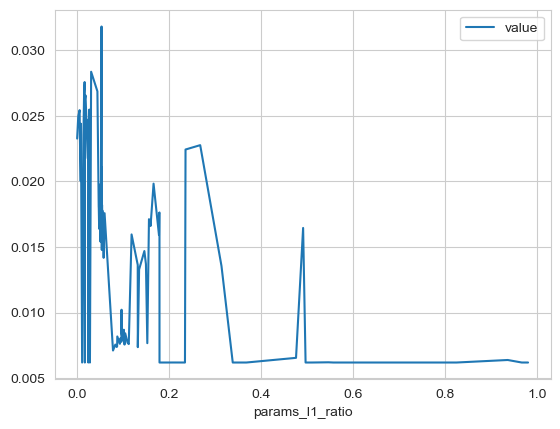

In [32]:
results = study.trials_dataframe()
results = results[['params_r', 'params_l1_ratio', 'value']]
results.sort_values('params_r').plot('params_r', 'value')
results.sort_values('params_l1_ratio').plot('params_l1_ratio', 'value')

In [30]:
model = ElasticNet(alpha=10 ** study.best_params['r'], l1_ratio=study.best_params['l1_ratio'])
scores = cross_validate(model, X, y_log, cv=4, scoring=['neg_mean_squared_error', 'r2'], return_train_score=True)
print('Train MSE:', scores['train_neg_mean_squared_error'].mean())
print('Test MSE:', scores['test_neg_mean_squared_error'].mean())
print('Train R2:', scores['train_r2'].mean())
print('Test R2:', scores['test_r2'].mean())
model.fit(X, y_log)
cfs = pd.DataFrame({'coef':model.coef_, 'feature':columns})
cfs['cfsabs'] = np.abs(cfs.coef)
print((cfs).sort_values('cfsabs', ascending=False).head(10))
print(model.intercept_)

Train MSE: -0.6461035412704076
Test MSE: -0.7439660657695177
Train R2: 0.17731192456875466
Test R2: 0.03180480125110802
        coef                     feature
25  0.168131                  kw_avg_avg
0   0.121466                   timedelta
11  0.078847                num_keywords
6   0.057709                   num_hrefs
36  0.049968                  is_weekend
35  0.027791           weekday_is_sunday
28  0.026367  self_reference_avg_sharess
8   0.023666                    num_imgs
50  0.021654       max_positive_polarity
22  0.021569                  kw_avg_max
7.430064470959853
